## Multi-layer perceptron (MLP)
In this second notebook of makemore, we are going to implement a MLP. The drawback of our previous approach is that the dimensionality of n-grams scale exponentially as we increase n. Hence, we want a more robust method that does not computationally scale exponentially.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
# create mapping from characters to integers and vice versa
# special character . denotes start and end of name, and is given a '0'
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Next, we create the dataset.

In [6]:
block_size = 3 # context length: how many characters we take to predict the next character
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
def build_dataset(words):
    block_size = 3 # context length: how many characters we take to predict the next character
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

Next, we create our train, val and test sets.

In [9]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

In [10]:
X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [11]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # 27 characters, embedding size 10
W1 = torch.randn((30, 200) , generator=g) # 30 = 3 * 10, 200 is magic number for hidden dim
b1 = torch.randn((200,), generator=g)
W2 = torch.randn((200, 27), generator=g) # 27 as we need to predict out of 27 characters
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

In [12]:
num_parameters = sum([p.numel() for p in parameters])
num_parameters

11897

In [13]:
for p in parameters:
    p.requires_grad = True

In [14]:
# to find best learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [15]:
# to keep track of learning rate and respective loss
lri = []
lossi = []
stepi = []

In [16]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y_train[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # learning rate decay update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())


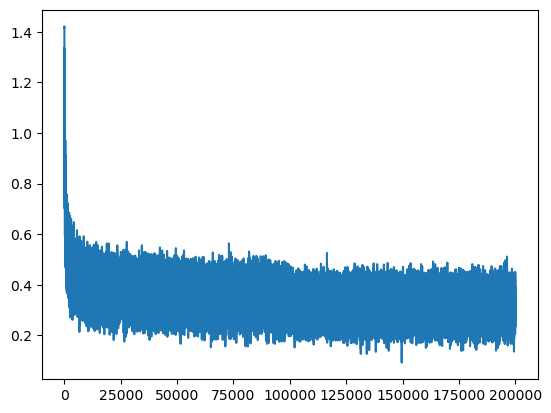

In [17]:
plt.plot(stepi, lossi)

We see that the training loss fluctuates because we are taking mini-batches. We can calculate our train and validation loss.

In [18]:
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Y_train)
train_loss

tensor(2.1157, grad_fn=<NllLossBackward0>)

In [19]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, Y_val)
val_loss

tensor(2.1589, grad_fn=<NllLossBackward0>)

Train and validation losses are very similar, which means that we are not overfitting. Lastly, we want to sample from the model and generate some names.

In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamillivi.
kimri.
reviyah.
cassie.
rahuen.
delynn.
jareen.
nermara.
chriivia.
leigh.
ham.
porniquinn.
suline.
liven.
corterri.
jarynix.
kaeklinslee.
dae.
oia.
gina.


This is actually not bad! We are starting to see some patterns of name-like words appearing.

## Exercises
### E01
Karpathy: Tune the hyperparameters of the training to beat my best validation loss of 2.2.

Me: Some hyperparameters that I can work on tuning include- size of hidden layers, even greater lr decay for the last few iterations, and the mini batch size.

I'll start with lr decay since that seems like the lowest hanging fruit.

In [21]:
def init_weights():
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g, requires_grad=True) # 27 characters, embedding size 10
    W1 = torch.randn((30, 200) , generator=g, requires_grad=True) # 30 = 3 * 10, 200 is magic number for hidden dim
    b1 = torch.randn((200,), generator=g, requires_grad=True)
    W2 = torch.randn((200, 27), generator=g, requires_grad=True) # 27 as we need to predict out of 27 characters
    b2 = torch.randn((27,), generator=g, requires_grad=True)

    return [C, W1, b1, W2, b2]

In [22]:
parameters = init_weights()

for p in parameters:
    p.requires_grad = True

In [23]:
C, W1, b1, W2, b2 = parameters

In [24]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y_train[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # learning rate decay update
  #lr = lrs[i]
  if i < 100000:
    lr = 0.1
  elif i < 180000:
    lr = 0.01
  else:
    lr = 0.001
  for p in parameters:
    p.data += -lr * p.grad

In [25]:
def calc_loss(X, Y, C, W1, b1, W2, b2):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    val_loss = F.cross_entropy(logits, Y)
    return val_loss

In [26]:
calc_loss(X_val, Y_val, C, W1, b1, W2, b2)

tensor(2.1491, grad_fn=<NllLossBackward0>)

We see that using an even smaller learning rate as we approach the last few iterations can give us even lower validation score.

### E02
#### Karpathy
I was not careful with the intialization of the network in this video. 

(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 

(2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

#### Me
To get perfectly uniform predicted probabilities to be zero, the logits must be uniform. Thus, `b2` must be a constant, and `W2` has to be all zeros. Since `W2` is all zeros, neither `W1` nor `b1` matters, since their output will be multiplied by a zero matrix in `W2`. Likewise for `C`.

In [27]:
def init_uniform_prob_weights():
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g, requires_grad=True) # 27 characters, embedding size 10
    W1 = torch.randn((30, 200) , generator=g, requires_grad=True) # 30 = 3 * 10, 200 is magic number for hidden dim
    b1 = torch.randn((200,), generator=g, requires_grad=True)
    W2 = torch.zeros((200, 27), requires_grad=True) # 27 as we need to predict out of 27 characters
    b2 = torch.ones((27,), requires_grad=True)

    return [C, W1, b1, W2, b2]

In [28]:
parameters = init_uniform_prob_weights()

for p in parameters:
    p.requires_grad = True

C, W1, b1, W2, b2 = parameters

In [29]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y_train[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # learning rate decay update
  #lr = lrs[i]
  if i < 100000:
    lr = 0.1
  elif i < 180000:
    lr = 0.01
  else:
    lr = 0.001
  for p in parameters:
    p.data += -lr * p.grad

In [30]:
calc_loss(X_val, Y_val, C, W1, b1, W2, b2)

tensor(2.1223, grad_fn=<NllLossBackward0>)

Interestingly starting with a uniform predicted output gives even lower validation loss post training.

In addition, I initially thought that this answer is what Karpathy wanted for (1). However, I think he wanted me to provide an analysis for (1), and to use tuning for (2).

Analysis for (1): If predicted probability was uniform for all classes, then L = -Σ y_i * log(p_i) simplifies to L = -log(1/n) = log(n). log(27) = 1.43

Now for (2), I can initialise the embeddings, weights and biases to have mean of 0 but much smaller variance, say 0.001. This helps to make the output more similar, but still have enough variance between the entries in the matrices and vectors such that back propagation can be processed accordingly.

In [31]:
def init_similar_weights(variance):
    g = torch.Generator().manual_seed(2147483647)
    C = torch.normal(0, variance ** 0.5, (27, 10), generator=g, requires_grad=True) # 27 characters, embedding size 10
    W1 = torch.normal(0, variance ** 0.5, (30, 200) , generator=g, requires_grad=True) # 30 = 3 * 10, 200 is magic number for hidden dim
    b1 = torch.zeros((200,), requires_grad=True)
    W2 = torch.normal(0, variance ** 0.5, (200, 27), generator=g, requires_grad=True) # 27 as we need to predict out of 27 characters
    b2 = torch.zeros((27,), requires_grad=True)

    return [C, W1, b1, W2, b2]

In [32]:
parameters = init_similar_weights(0.025)

for p in parameters:
    p.requires_grad = True

C, W1, b1, W2, b2 = parameters

In [33]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y_train[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # learning rate decay update
  #lr = lrs[i]
  if i < 100000:
    lr = 0.1
  elif i < 180000:
    lr = 0.01
  else:
    lr = 0.001
  for p in parameters:
    p.data += -lr * p.grad

In [34]:
calc_loss(X_val, Y_val, C, W1, b1, W2, b2)

tensor(2.1032, grad_fn=<NllLossBackward0>)

After trying different values of variance, having a variance of 0.025 produces a loss of 2.0997, which is lower than when we set `W2` to be zeros and `b2` to be 1.

### E03
Karpathy: Try any idea from the paper.

Me: One thing I'll like to try is to intrepret our feature embedding. While Karpathy has demonstrated the interpretation of the features when the embedding dimension is 2, I'll like to use PCA to first reduce dimensionality of `C` from 10 to 3, and then plot them.

In [35]:
import numpy as np
from sklearn.decomposition import PCA

In [37]:
C_numpy = C.detach().cpu().numpy()
pca = PCA(n_components=3)
C_compressed_numpy = pca.fit_transform(C_numpy)

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

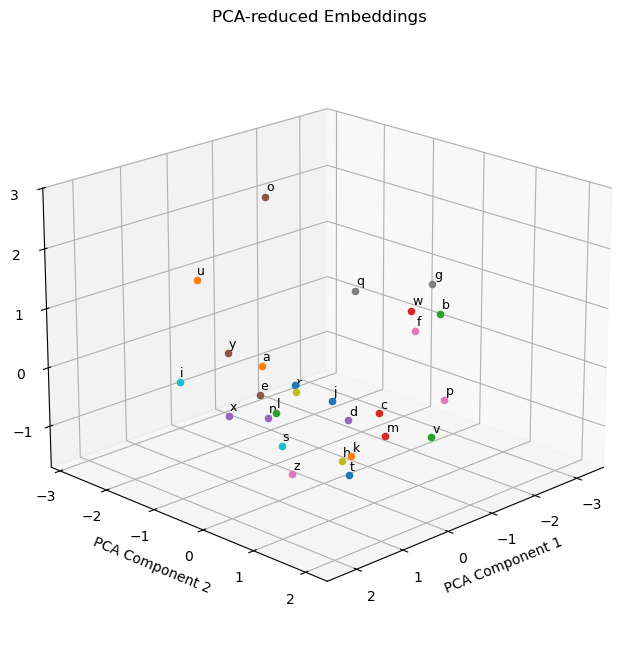

In [42]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(C_compressed_numpy.shape[0]):
    x, y, z = C_compressed_numpy[i]
    ax.scatter(x, y, z)
    
    label = itos[i]  # Assuming itos maps integers to characters
    ax.text(x + 0.2, y + 0.2, z + 0.2, label, fontsize=9)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.title('PCA-reduced Embeddings')

ax.view_init(elev=20, azim=45)

plt.show()

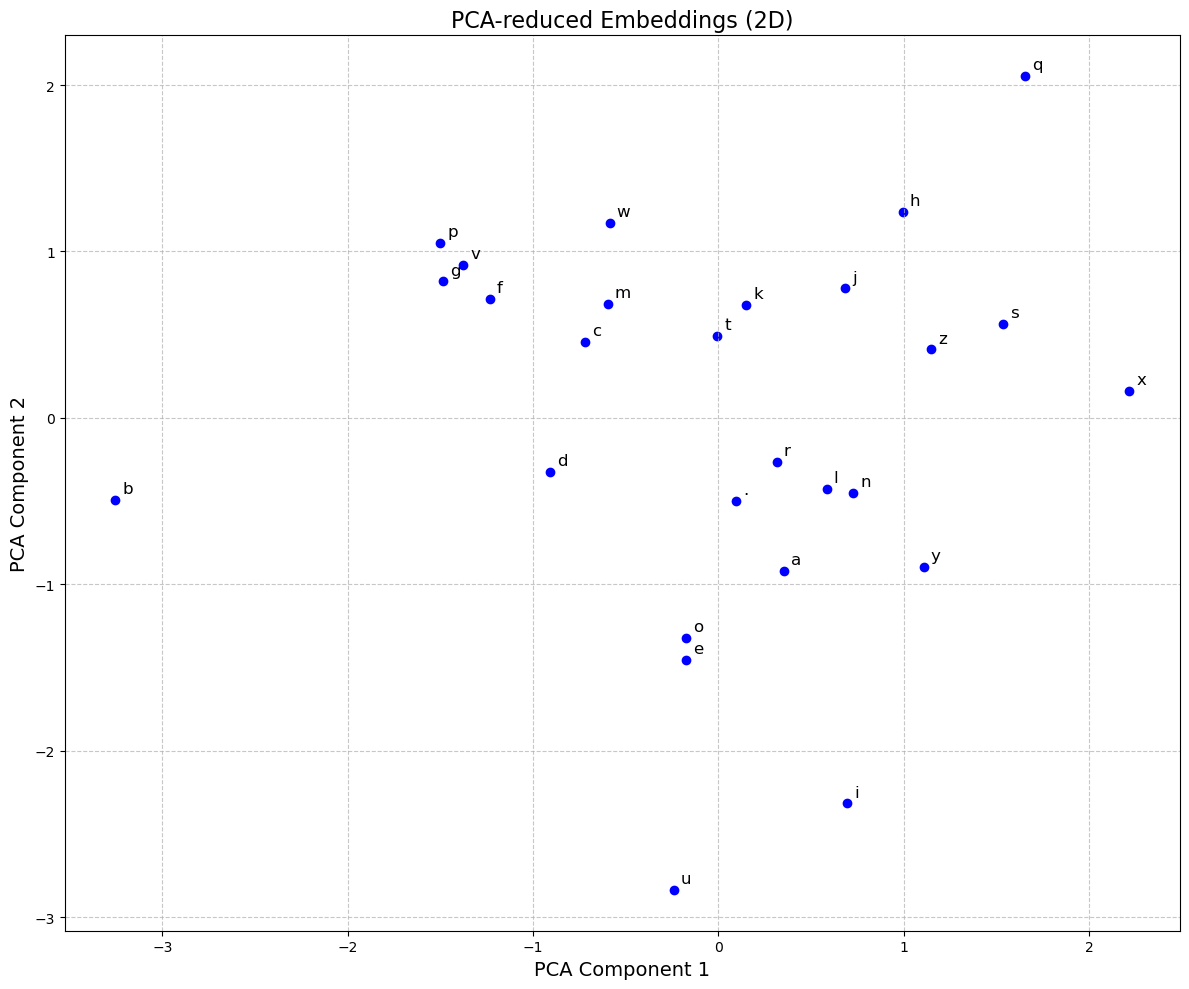

In [45]:
C_compressed_numpy = PCA(n_components=2).fit_transform(C_numpy)

plt.figure(figsize=(12, 10))

# Plot each point
for i in range(C_compressed_numpy.shape[0]):
    x, y = C_compressed_numpy[i]
    plt.scatter(x, y, color='blue')
    
    # Add label to each point with an offset
    label = itos[i]  # Assuming itos maps integers to characters
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=12)

# Set labels for each axis
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)

# Set a title for the plot
plt.title('PCA-reduced Embeddings (2D)', fontsize=16)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

The 2D plot is easier to view and understand than the 3D plot. It's interesting to note that the vowels are not that close together in the cluster. b, x, q are also characters that are really far apart from other characters. This is probably most surprising for b, since it does not seem to be that 'rare' of a character.